# preprocessing steps

## step 1. Read txt file
## step 2. SMILES string validation
## step 3. Correct problematic SMILES strings
## step 4. Duplication check: 1203 dp to 1115 dp
## step 5. Remove the duplicates, keep the highest PCE record
## step 6. Sort database by the number of atoms with hydrogen (atom_num_wH)

In [5]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdmolops, AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity='all'


In [7]:
df = pd.read_csv('./raw/saeki-2018-jpcl.txt', sep = '\t', header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,ID No.,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),-HOMO (eV),-LUMO (eV),bandgap(eV),SMILES
1,1,PBTTT-C14,S1,2.34,2.34,0.530,9.370,0.480,46.2,22.0,2.10,724,5.10,3.10,1.88,CC1=CC(CCCCCCCCCCCCCC)=C(C2=CC3=C(S2)C=C(C4=C(...
2,2,PCDTBT,S2,3.60,3.60,0.890,6.920,0.630,73.0,37.0,1.97,731,5.50,3.60,1.88,CC1=CC(N(C(CCCCCCCC)CCCCCCCC)C2=C3C=CC(C4=CC=C...
3,3,PCPDTBT,S3,5.12,5.12,0.610,15.730,0.530,47.6,26.6,1.79,564,5.30,3.55,1.43,CC1=CC(C(CC(CCCC)CC)(CC(CCCC)CC)C2=C3SC(C4=CC=...
4,4,PffBT4T-2OD,S4,10.50,10.20,0.770,18.400,0.740,93.7,47.5,1.97,1089,5.34,3.69,1.65,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=C(F)C(F)=C...


In [8]:
df_new = df.iloc[1:, 1:,]
df_new.columns = df.iloc[0,1:].values
df_new.head()
# df_new.describe()

,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),-HOMO (eV),-LUMO (eV),bandgap(eV),SMILES
1,PBTTT-C14,S1,2.34,2.34,0.530,9.370,0.480,46.2,22.0,2.10,724,5.10,3.10,1.88,CC1=CC(CCCCCCCCCCCCCC)=C(C2=CC3=C(S2)C=C(C4=C(...
2,PCDTBT,S2,3.60,3.60,0.890,6.920,0.630,73.0,37.0,1.97,731,5.50,3.60,1.88,CC1=CC(N(C(CCCCCCCC)CCCCCCCC)C2=C3C=CC(C4=CC=C...
3,PCPDTBT,S3,5.12,5.12,0.610,15.730,0.530,47.6,26.6,1.79,564,5.30,3.55,1.43,CC1=CC(C(CC(CCCC)CC)(CC(CCCC)CC)C2=C3SC(C4=CC=...
4,PffBT4T-2OD,S4,10.50,10.20,0.770,18.400,0.740,93.7,47.5,1.97,1089,5.34,3.69,1.65,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=C(F)C(F)=C...
5,PffBT4T-2OD,S4,10.40,10.00,0.770,18.200,0.740,52.9,28.2,1.88,1089,5.20,3.57,1.63,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=CC=C(C3=CC...


In [9]:
df_new.isna().sum()

Nickname              0
Ref. No               0
PCE_max(%)            0
PCE_ave(%)            0
Voc (V)               0
Jsc (mA cm^2)         0
FF                    0
Mw (kg mol^-1)        0
Mn (kg mol^-1)        0
PDI (=Mw/Mn)          0
Monomer (g mol^-1)    0
-HOMO (eV)            0
-LUMO (eV)            0
bandgap(eV)           0
SMILES                0
dtype: int64

In [10]:
df_new.nunique()

Nickname              1059
Ref. No                503
PCE_max(%)             603
PCE_ave(%)             606
Voc (V)                128
Jsc (mA cm^2)          735
FF                     304
Mw (kg mol^-1)         792
Mn (kg mol^-1)         529
PDI (=Mw/Mn)           291
Monomer (g mol^-1)     672
-HOMO (eV)             126
-LUMO (eV)             150
bandgap(eV)            116
SMILES                1163
dtype: int64

# carnonical SMILES test

In [11]:
smiles_list = df_new['SMILES'].unique()
len(smiles_list)

1163

In [7]:
# proof and make a list of SMILES
c_smiles = []
for ds in smiles_list:
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles.append(cs)
    except:
        print('Invalid SMILES:', ds)
#         df_new = df_new.drop(df_new[df_new['smiles-n']==ds].index)


[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not removing hydrogen atom without neighbors
[17:47:11] WARNING: not r

In [8]:
len(c_smiles)

1163

# problematic SMILES: smiles_list[64, 65]

[17:47:15] WARNING: not removing hydrogen atom without neighbors
[17:47:15] WARNING: not removing hydrogen atom without neighbors
[17:47:15] WARNING: not removing hydrogen atom without neighbors
[17:47:15] WARNING: not removing hydrogen atom without neighbors
[17:47:15] WARNING: not removing hydrogen atom without neighbors
[17:47:15] WARNING: not removing hydrogen atom without neighbors
[17:47:15] WARNING: not removing hydrogen atom without neighbors
[17:47:15] WARNING: not removing hydrogen atom without neighbors
[17:47:15] WARNING: not removing hydrogen atom without neighbors
[17:47:15] WARNING: not removing hydrogen atom without neighbors
[17:47:15] WARNING: not removing hydrogen atom without neighbors
[17:47:15] WARNING: not removing hydrogen atom without neighbors


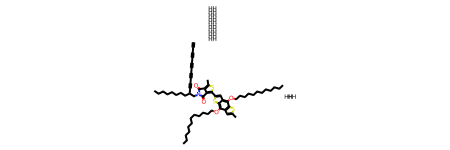

In [9]:
mol = Chem.MolFromSmiles(smiles_list[64])
mol

In [10]:
smiles_list[64]

'CC(S1)=CC2=C1C(OCCCCCCCCCCCC)=C(C=C(C3=C4C(C(N(CC(C#CC#CC#CC#CC#C)CCCCCCCC)C4=O)=O)=C(C)S3)S5)C5=C2OCCCCCCCCCCCC.[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH]'

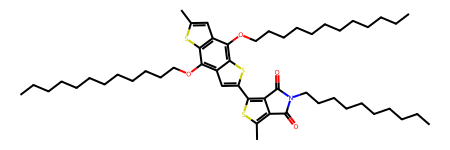

In [11]:
smiles_r = 'C(CCCCCCCC)CN1C(=O)c2c(C)sc(-c3cc4c(OCCCCCCCCCCCC)c5sc(C)cc5c(OCCCCCCCCCCCC)c4s3)c2C1=O'
Chem.MolFromSmiles(smiles_r)

In [12]:
df_new[df_new['SMILES']==smiles_list[64]]
# df_new['SMILES'][df_new['SMILES']==smiles_list[64]].values
# df_new['SMILES']

,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),-HOMO (eV),-LUMO (eV),bandgap(eV),SMILES
71,PBDTDPT1,S34,3.42,3.42,0.930,6.580,0.560,157.5,43.5,3.62,1022,5.42,3.60,1.84,CC(S1)=CC2=C1C(OCCCCCCCCCCCC)=C(C=C(C3=C4C(C(N...


In [13]:
df_new.loc[df_new['SMILES']==smiles_list[64],'SMILES']=smiles_r
df_new[df_new['SMILES'] == smiles_r]

,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),-HOMO (eV),-LUMO (eV),bandgap(eV),SMILES
71,PBDTDPT1,S34,3.42,3.42,0.930,6.580,0.560,157.5,43.5,3.62,1022,5.42,3.60,1.84,C(CCCCCCCC)CN1C(=O)c2c(C)sc(-c3cc4c(OCCCCCCCCC...


[17:47:27] WARNING: not removing hydrogen atom without neighbors
[17:47:27] WARNING: not removing hydrogen atom without neighbors
[17:47:27] WARNING: not removing hydrogen atom without neighbors
[17:47:27] WARNING: not removing hydrogen atom without neighbors
[17:47:27] WARNING: not removing hydrogen atom without neighbors
[17:47:27] WARNING: not removing hydrogen atom without neighbors
[17:47:27] WARNING: not removing hydrogen atom without neighbors
[17:47:27] WARNING: not removing hydrogen atom without neighbors
[17:47:27] WARNING: not removing hydrogen atom without neighbors
[17:47:27] WARNING: not removing hydrogen atom without neighbors
[17:47:27] WARNING: not removing hydrogen atom without neighbors
[17:47:27] WARNING: not removing hydrogen atom without neighbors


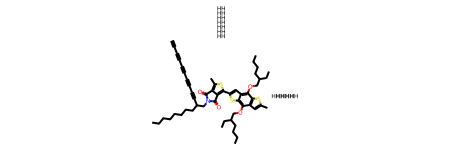

In [14]:
mol = Chem.MolFromSmiles(smiles_list[65])
mol

In [15]:
smiles_list[65]

'CC(S1)=CC2=C1C(OCC(CCCC)CC)=C(C=C(C3=C4C(C(N(CC(C#CC#CC#CC#CC#C)CCCCCCCC)C4=O)=O)=C(C)S3)S5)C5=C2OCC(CCCC)CC.[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH]'

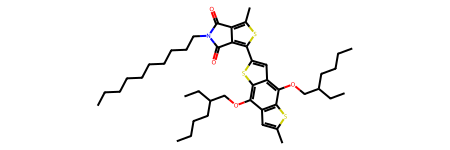

In [16]:
smiles_r = 'CC(S1)=CC2=C1C(OCC(CCCC)CC)=C(C=C(C3=C4C(C(N(CCCCCCCCCC)C4=O)=O)=C(C)S3)S5)C5=C2OCC(CCCC)CC'
Chem.MolFromSmiles(smiles_r)

In [17]:
df_new[df_new['SMILES']==smiles_list[65]]


,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),-HOMO (eV),-LUMO (eV),bandgap(eV),SMILES
72,PBDTDPT2,S34,4.79,4.79,0.910,10.340,0.510,600.3,91.1,6.59,910,5.44,3.58,1.84,CC(S1)=CC2=C1C(OCC(CCCC)CC)=C(C=C(C3=C4C(C(N(C...


In [18]:
df_new.loc[df_new['SMILES']==smiles_list[65],'SMILES']=smiles_r
df_new[df_new['SMILES'] == smiles_r]

,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),-HOMO (eV),-LUMO (eV),bandgap(eV),SMILES
72,PBDTDPT2,S34,4.79,4.79,0.910,10.340,0.510,600.3,91.1,6.59,910,5.44,3.58,1.84,CC(S1)=CC2=C1C(OCC(CCCC)CC)=C(C=C(C3=C4C(C(N(C...


# double-check

In [19]:
smiles_list = df_new['SMILES'].values
smiles_list

array(['CC1=CC(CCCCCCCCCCCCCC)=C(C2=CC3=C(S2)C=C(C4=C(CCCCCCCCCCCCCC)C=C(C)S4)S3)S1',
       'CC1=CC(N(C(CCCCCCCC)CCCCCCCC)C2=C3C=CC(C4=CC=C(C5=CC=C(C6=CC=C(C)S6)C7=NSN=C57)S4)=C2)=C3C=C1',
       'CC1=CC(C(CC(CCCC)CC)(CC(CCCC)CC)C2=C3SC(C4=CC=C(C)C5=NSN=C45)=C2)=C3S1',
       ...,
       'CC1=CC(N(CCCCCCCC)C2=C3C=CC(C4=CC=C(C5=C(OCCCCCCCC)C(OCCCCCCCC)=C(C6=CC=C(C)S6)C7=C5N=C(C8=CC=CC(OCCCCCCCC)=C8)C(C9=CC(OCCCCCCCC)=CC=C9)=N7)S4)=C2)=C3C=C1',
       'CC1=CC(N(CCCCCCCC)C2=C3C=CC(C4=CC=C(C5=C(OCCCCCCCC)C(OCCCCCCCC)=C(C6=CC=C(C)S6)C7=C5N=C(C8=CC=C(OCCCCCCCC)C=C8)C(C9=CC=C(OCCCCCCCC)C=C9)=N7)S4)=C2)=C3C=C1',
       'CC1=CC2=C(C(OCCCCCCCC)=C(C=C(C3=C4C(C=C(/C=C(C(OCC(CCCCCCCC)CCCCCCCCCC)=O)/C#N)S4)=C(C)S3)S5)C5=C2OCCCCCCCC)S1'],
      dtype=object)

In [20]:
# proof and make a list of SMILES
c_smiles = []
for ds in smiles_list:
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles.append(cs)
    except:
        print('Invalid SMILES:', ds)
#         df_new = df_new.drop(df_new[df_new['smiles-n']==ds].index)

In [21]:
# import os  
# os.makedirs('./raw', exist_ok=True)
# df_new.to_csv('./raw/saeki-2018-jpcl-corrected.csv', index=False)

# search for duplicated donors, keep the highest PCE record

In [21]:
df = pd.read_csv('./raw/saeki-2018-jpcl-corrected.csv')
df.head()

,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),-HOMO (eV),-LUMO (eV),bandgap(eV),SMILES
0,PBTTT-C14,S1,2.34,2.34,0.53,9.37,0.48,46.2,22.0,2.10,724,5.10,3.10,1.88,CC1=CC(CCCCCCCCCCCCCC)=C(C2=CC3=C(S2)C=C(C4=C(...
1,PCDTBT,S2,3.60,3.60,0.89,6.92,0.63,73.0,37.0,1.97,731,5.50,3.60,1.88,CC1=CC(N(C(CCCCCCCC)CCCCCCCC)C2=C3C=CC(C4=CC=C...
2,PCPDTBT,S3,5.12,5.12,0.61,15.73,0.53,47.6,26.6,1.79,564,5.30,3.55,1.43,CC1=CC(C(CC(CCCC)CC)(CC(CCCC)CC)C2=C3SC(C4=CC=...
3,PffBT4T-2OD,S4,10.50,10.20,0.77,18.40,0.74,93.7,47.5,1.97,1089,5.34,3.69,1.65,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=C(F)C(F)=C...
4,PffBT4T-2OD,S4,10.40,10.00,0.77,18.20,0.74,52.9,28.2,1.88,1089,5.20,3.57,1.63,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=CC=C(C3=CC...


### canonical SMILES

In [22]:
smiles_list = df['SMILES']

c_smiles = []
for ds in smiles_list:
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles.append(cs)
    except:
        print('Invalid SMILES:', ds)
len(c_smiles)

1203

In [29]:
df['c_smiles'] = c_smiles
df

,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),-HOMO (eV),-LUMO (eV),bandgap(eV),SMILES,c_smiles
0,PBTTT-C14,S1,2.34,2.34,0.53,9.37,0.480,46.2,22.0,2.10,724,5.10,3.10,1.88,CC1=CC(CCCCCCCCCCCCCC)=C(C2=CC3=C(S2)C=C(C4=C(...,CCCCCCCCCCCCCCc1cc(C)sc1-c1cc2sc(-c3sc(C)cc3CC...
1,PCDTBT,S2,3.60,3.60,0.89,6.92,0.630,73.0,37.0,1.97,731,5.50,3.60,1.88,CC1=CC(N(C(CCCCCCCC)CCCCCCCC)C2=C3C=CC(C4=CC=C...,CCCCCCCCC(CCCCCCCC)n1c2cc(C)ccc2c2ccc(-c3ccc(-...
2,PCPDTBT,S3,5.12,5.12,0.61,15.73,0.530,47.6,26.6,1.79,564,5.30,3.55,1.43,CC1=CC(C(CC(CCCC)CC)(CC(CCCC)CC)C2=C3SC(C4=CC=...,CCCCC(CC)CC1(CC(CC)CCCC)c2cc(C)sc2-c2sc(-c3ccc...
3,PffBT4T-2OD,S4,10.50,10.20,0.77,18.40,0.740,93.7,47.5,1.97,1089,5.34,3.69,1.65,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=C(F)C(F)=C...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(-c2c(F)c(F)c(-c3cc(...
4,PffBT4T-2OD,S4,10.40,10.00,0.77,18.20,0.740,52.9,28.2,1.88,1089,5.20,3.57,1.63,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=CC=C(C3=CC...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(-c2ccc(-c3cc(CC(CCC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,PTTIMBI,S500,2.60,2.60,0.69,7.10,0.530,27.0,12.0,2.19,665,5.29,3.61,1.54,CC1=CC=C(C2=CC3=C(C(SC(C4=CC=C(C)C5=NC(C)(C)N=...,CCCCCCCCC(CCCCCCCC)n1c2cc(-c3ccc(C)s3)ccc2c2sc...
1199,pDSBT-BHTBT,S501,3.76,3.76,0.89,8.64,0.490,14.7,9.2,1.60,942,5.20,3.40,1.80,CC1=CC2=C(C(SC(C3=C(CCCCCC)C=C(C4=CC=C(C5=CC(C...,CCCCCCc1cc(-c2ccc(-c3cc(CCCCCC)c(-c4cc5c(s4)-c...
1200,P1,S502,1.51,1.44,0.87,3.77,0.460,25.1,13.7,1.83,1264,5.49,3.50,1.99,CC1=CC(N(CCCCCCCC)C2=C3C=CC(C4=CC=C(C5=C(OCCCC...,CCCCCCCCOc1cccc(-c2nc3c(-c4ccc(C)s4)c(OCCCCCCC...
1201,P2,S502,3.33,3.21,0.86,7.48,0.520,21.4,12.6,1.69,1264,5.41,3.39,2.02,CC1=CC(N(CCCCCCCC)C2=C3C=CC(C4=CC=C(C5=C(OCCCC...,CCCCCCCCOc1ccc(-c2nc3c(-c4ccc(C)s4)c(OCCCCCCCC...


In [24]:
smiles_list = df['c_smiles'].unique()
len(smiles_list)

1115

In [33]:
# for value in smiles_list:
#     match = df[df['c_smiles']==value]
#     if match.shape[0]>1:
#         print(match)

### keep the highest PCE record

In [25]:
df_new = df.sort_values(by = 'PCE_max(%)',  axis = 0, ascending = False)
df_new

,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),-HOMO (eV),-LUMO (eV),bandgap(eV),SMILES,c_smiles
661,"PffBT-T3(1,2)-2",S264,10.70,10.50,0.82,18.70,0.683,109.6,66.1,1.66,1731,5.31,3.68,1.63,FC(C(F)=C(C1=CC(CC(CCCCCC)CCCCCCCC)=C(C2=CC(CC...,CCCCCCCCC(CCCCCC)Cc1cc(-c2c(F)c(F)c(-c3cc(CC(C...
3,PffBT4T-2OD,S4,10.50,10.20,0.77,18.40,0.740,93.7,47.5,1.97,1089,5.34,3.69,1.65,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=C(F)C(F)=C...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(-c2c(F)c(F)c(-c3cc(...
263,PNTz4TF2,S106,10.50,10.10,0.82,19.30,0.670,1520.0,66.5,22.90,1309,5.38,3.53,1.60,CC1=C(CC(CCCCCCCCCC)CCCCCCCCCCCC)C=C(C2=CC(C3=...,CCCCCCCCCCCCC(CCCCCCCCCC)Cc1cc(-c2cc3c(cc(-c4c...
4,PffBT4T-2OD,S4,10.40,10.00,0.77,18.20,0.740,52.9,28.2,1.88,1089,5.20,3.57,1.63,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=CC=C(C3=CC...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(-c2ccc(-c3cc(CC(CCC...
279,NT812,S112,10.33,10.18,0.72,19.09,0.729,118.9,56.6,2.10,1135,5.29,3.40,1.40,CC1=CC(CC(CCCCCCCCCC)CCCCCCCC)=C(C2=CC(SC(C3=C...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(C)sc1-c1cc2sc(-c3sc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,P2,S355,0.06,0.06,0.28,0.51,0.337,9.3,4.6,1.78,817,4.76,2.79,1.68,CC1=CC=C(C2=C(CCCCCC)N=C(C3=NC(CCCCCC)=C(C4=CC...,CCCCCCc1nc(-c2nc(CCCCCC)c(-c3ccc(-c4cc5c(s4)c4...
1007,PTBI2Tz,S414,0.05,0.05,0.40,0.34,0.320,517.0,114.0,4.54,1311,6.12,3.56,1.91,O=C(N1CC(CCCCCCCCCC)CCCCCCCCCCCC)C2C=C(C)SC2C3...,CCCCCCCCCCCCC(CCCCCCCCCC)CN1C(=O)c2c(sc3c2sc2c...
498,PFL-CPDTO (P4),S202,0.03,0.03,0.68,0.11,0.280,28.1,17.9,1.57,734,5.92,3.06,2.39,CC1=C(C(SC(C(CCCCCCC)=O)=C2)=C2C3=O)C3=C(C4=CC...,CCCCCCCCC1(CCCCCCCC)c2cc(C)ccc2-c2ccc(-c3sc(C)...
938,PTVcBBO,S382,0.01,0.01,0.35,0.12,0.260,13.4,5.6,2.40,658,5.19,3.02,2.17,CC1=NC2=C(C=C(OC(/C=C/C3=C(CCCCCCCCCCCC)C(CCCC...,C/C=C/c1sc(/C=C/c2nc3cc4nc(C)oc4cc3o2)c(CCCCCC...


In [26]:
df_new = df_new.drop_duplicates(subset=['c_smiles'], keep = 'first')
df_new

,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),-HOMO (eV),-LUMO (eV),bandgap(eV),SMILES,c_smiles
661,"PffBT-T3(1,2)-2",S264,10.70,10.50,0.82,18.70,0.683,109.6,66.1,1.66,1731,5.31,3.68,1.63,FC(C(F)=C(C1=CC(CC(CCCCCC)CCCCCCCC)=C(C2=CC(CC...,CCCCCCCCC(CCCCCC)Cc1cc(-c2c(F)c(F)c(-c3cc(CC(C...
3,PffBT4T-2OD,S4,10.50,10.20,0.77,18.40,0.740,93.7,47.5,1.97,1089,5.34,3.69,1.65,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=C(F)C(F)=C...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(-c2c(F)c(F)c(-c3cc(...
263,PNTz4TF2,S106,10.50,10.10,0.82,19.30,0.670,1520.0,66.5,22.90,1309,5.38,3.53,1.60,CC1=C(CC(CCCCCCCCCC)CCCCCCCCCCCC)C=C(C2=CC(C3=...,CCCCCCCCCCCCC(CCCCCCCCCC)Cc1cc(-c2cc3c(cc(-c4c...
4,PffBT4T-2OD,S4,10.40,10.00,0.77,18.20,0.740,52.9,28.2,1.88,1089,5.20,3.57,1.63,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=CC=C(C3=CC...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(-c2ccc(-c3cc(CC(CCC...
279,NT812,S112,10.33,10.18,0.72,19.09,0.729,118.9,56.6,2.10,1135,5.29,3.40,1.40,CC1=CC(CC(CCCCCCCCCC)CCCCCCCC)=C(C2=CC(SC(C3=C...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(C)sc1-c1cc2sc(-c3sc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,P2,S355,0.06,0.06,0.28,0.51,0.337,9.3,4.6,1.78,817,4.76,2.79,1.68,CC1=CC=C(C2=C(CCCCCC)N=C(C3=NC(CCCCCC)=C(C4=CC...,CCCCCCc1nc(-c2nc(CCCCCC)c(-c3ccc(-c4cc5c(s4)c4...
1007,PTBI2Tz,S414,0.05,0.05,0.40,0.34,0.320,517.0,114.0,4.54,1311,6.12,3.56,1.91,O=C(N1CC(CCCCCCCCCC)CCCCCCCCCCCC)C2C=C(C)SC2C3...,CCCCCCCCCCCCC(CCCCCCCCCC)CN1C(=O)c2c(sc3c2sc2c...
498,PFL-CPDTO (P4),S202,0.03,0.03,0.68,0.11,0.280,28.1,17.9,1.57,734,5.92,3.06,2.39,CC1=C(C(SC(C(CCCCCCC)=O)=C2)=C2C3=O)C3=C(C4=CC...,CCCCCCCCC1(CCCCCCCC)c2cc(C)ccc2-c2ccc(-c3sc(C)...
938,PTVcBBO,S382,0.01,0.01,0.35,0.12,0.260,13.4,5.6,2.40,658,5.19,3.02,2.17,CC1=NC2=C(C=C(OC(/C=C/C3=C(CCCCCCCCCCCC)C(CCCC...,C/C=C/c1sc(/C=C/c2nc3cc4nc(C)oc4cc3o2)c(CCCCCC...


In [27]:
# df_new.to_csv('./raw/saeki-2018-jpcl-corrected-c_smiles-1115.csv', index=False)

# sort by no_atom_w_H

In [34]:
df = pd.read_csv('./raw/saeki-2018-jpcl-corrected-c_smiles-1115.csv')
df.head()

,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),-HOMO (eV),-LUMO (eV),bandgap(eV),SMILES,c_smiles
0,"PffBT-T3(1,2)-2",S264,10.70,10.50,0.82,18.70,0.683,109.6,66.1,1.66,1731,5.31,3.68,1.63,FC(C(F)=C(C1=CC(CC(CCCCCC)CCCCCCCC)=C(C2=CC(CC...,CCCCCCCCC(CCCCCC)Cc1cc(-c2c(F)c(F)c(-c3cc(CC(C...
1,PffBT4T-2OD,S4,10.50,10.20,0.77,18.40,0.740,93.7,47.5,1.97,1089,5.34,3.69,1.65,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=C(F)C(F)=C...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(-c2c(F)c(F)c(-c3cc(...
2,PNTz4TF2,S106,10.50,10.10,0.82,19.30,0.670,1520.0,66.5,22.90,1309,5.38,3.53,1.60,CC1=C(CC(CCCCCCCCCC)CCCCCCCCCCCC)C=C(C2=CC(C3=...,CCCCCCCCCCCCC(CCCCCCCCCC)Cc1cc(-c2cc3c(cc(-c4c...
3,PffBT4T-2OD,S4,10.40,10.00,0.77,18.20,0.740,52.9,28.2,1.88,1089,5.20,3.57,1.63,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=CC=C(C3=CC...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(-c2ccc(-c3cc(CC(CCC...
4,NT812,S112,10.33,10.18,0.72,19.09,0.729,118.9,56.6,2.10,1135,5.29,3.40,1.40,CC1=CC(CC(CCCCCCCCCC)CCCCCCCC)=C(C2=CC(SC(C3=C...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(C)sc1-c1cc2sc(-c3sc...


In [4]:
no_atom=[]
no_atom_w_H=[]
mol_weight=[]
aromatic_ring=[]

for smiles in df['c_smiles'].values:
    mol = Chem.MolFromSmiles(smiles)
    mol_H = Chem.rdmolops.AddHs(mol)
    
    no_atom.append(mol.GetNumAtoms())
    no_atom_w_H.append(mol_H.GetNumAtoms())
    mol_weight.append(Chem.Descriptors.MolWt(mol_H))
    aromatic_ring.append(Chem.rdMolDescriptors.CalcNumAromaticRings(mol_H))
    
df['no_atom'] = no_atom
df['no_atom_w_H'] = no_atom_w_H
df['mol_weight'] = mol_weight
df['aromatic_ring'] = aromatic_ring
df

,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),-HOMO (eV),-LUMO (eV),bandgap(eV),SMILES,c_smiles,no_atom,no_atom_w_H,mol_weight,aromatic_ring
0,"PffBT-T3(1,2)-2",S264,10.70,10.50,0.82,18.70,0.683,109.6,66.1,1.66,1731,5.31,3.68,1.63,FC(C(F)=C(C1=CC(CC(CCCCCC)CCCCCCCC)=C(C2=CC(CC...,CCCCCCCCC(CCCCCC)Cc1cc(-c2c(F)c(F)c(-c3cc(CC(C...,116,258,1732.792,10
1,PffBT4T-2OD,S4,10.50,10.20,0.77,18.40,0.740,93.7,47.5,1.97,1089,5.34,3.69,1.65,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=C(F)C(F)=C...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(-c2c(F)c(F)c(-c3cc(...,73,167,1089.801,6
2,PNTz4TF2,S106,10.50,10.10,0.82,19.30,0.670,1520.0,66.5,22.90,1309,5.38,3.53,1.60,CC1=C(CC(CCCCCCCCCC)CCCCCCCCCCCC)C=C(C2=CC(C3=...,CCCCCCCCCCCCC(CCCCCCCCCC)Cc1cc(-c2cc3c(cc(-c4c...,88,198,1310.142,8
3,PffBT4T-2OD,S4,10.40,10.00,0.77,18.20,0.740,52.9,28.2,1.88,1089,5.20,3.57,1.63,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=CC=C(C3=CC...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(-c2ccc(-c3cc(CC(CCC...,73,167,1089.801,6
4,NT812,S112,10.33,10.18,0.72,19.09,0.729,118.9,56.6,2.10,1135,5.29,3.40,1.40,CC1=CC(CC(CCCCCCCCCC)CCCCCCCC)=C(C2=CC(SC(C3=C...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(C)sc1-c1cc2sc(-c3sc...,76,170,1135.908,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,P2,S355,0.06,0.06,0.28,0.51,0.337,9.3,4.6,1.78,817,4.76,2.79,1.68,CC1=CC=C(C2=C(CCCCCC)N=C(C3=NC(CCCCCC)=C(C4=CC...,CCCCCCc1nc(-c2nc(CCCCCC)c(-c3ccc(-c4cc5c(s4)c4...,53,108,818.347,7
1111,PTBI2Tz,S414,0.05,0.05,0.40,0.34,0.320,517.0,114.0,4.54,1311,6.12,3.56,1.91,O=C(N1CC(CCCCCCCCCC)CCCCCCCCCCCC)C2C=C(C)SC2C3...,CCCCCCCCCCCCC(CCCCCCCCCC)CN1C(=O)c2c(sc3c2sc2c...,88,198,1312.120,6
1112,PFL-CPDTO (P4),S202,0.03,0.03,0.68,0.11,0.280,28.1,17.9,1.57,734,5.92,3.06,2.39,CC1=C(C(SC(C(CCCCCCC)=O)=C2)=C2C3=O)C3=C(C4=CC...,CCCCCCCCC1(CCCCCCCC)c2cc(C)ccc2-c2ccc(-c3sc(C)...,52,114,735.156,4
1113,PTVcBBO,S382,0.01,0.01,0.35,0.12,0.260,13.4,5.6,2.40,658,5.19,3.02,2.17,CC1=NC2=C(C=C(OC(/C=C/C3=C(CCCCCCCCCCCC)C(CCCC...,C/C=C/c1sc(/C=C/c2nc3cc4nc(C)oc4cc3o2)c(CCCCCC...,47,109,659.037,4


In [5]:
df_sort = df.sort_values(by = 'no_atom_w_H',  axis = 0, ascending = True)
df_sort


,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),-HOMO (eV),-LUMO (eV),bandgap(eV),SMILES,c_smiles,no_atom,no_atom_w_H,mol_weight,aromatic_ring
530,P3HT,S10,4.40,4.40,0.510,15.00,0.575,21.1,1.2,1.82,196,5.20,3.27,1.93,CC1=CC(CCCCCC)=C(C)S1,CCCCCCc1cc(C)sc1C,13,33,196.359,1
1086,P3HST,S123,0.34,0.34,0.630,1.27,0.340,28.5,15.0,1.90,228,4.90,3.08,1.82,CC1=CC(SCCCCCC)=C(C)S1,CCCCCCSc1cc(C)sc1C,14,34,228.426,1
916,POPT,S126,1.71,1.71,0.560,5.16,0.600,17.6,16.0,1.10,300,5.34,3.58,1.76,CC1=CC(C2=CC=C(CCCCCCCC)C=C2)=C(C)S1,CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1,21,49,300.511,2
919,PT-C1,S122,1.69,1.69,0.810,5.31,0.392,6.9,4.3,1.62,350,5.15,2.96,1.92,CC1=CC(C(OCC(CCCC)CC)=O)=C(C2=CC=C(C)S2)S1,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1,23,49,350.549,2
871,PT-C2,S122,2.14,2.14,0.810,5.44,0.484,5.6,3.2,1.75,432,5.11,2.95,1.89,CC1=CC(C(OCC(CCCC)CC)=O)=C(C2=CC=C(S2)C3=CC=C(...,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1,28,56,432.676,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,BTT-NTz,S115,2.73,2.73,0.755,5.98,0.605,62.7,39.9,1.57,2091,5.41,3.73,1.68,CC1=C(CC(CCCCCCCCCCCC)CCCCCCCCCC)C=C(S1)C(C2=N...,CCCCCCCCCCCCc1cc(C)sc1-c1cc2c3sc(C(CCCCCCCC)CC...,142,340,2093.634,12
572,PIDTI-BT,S441,4.02,4.02,0.820,8.99,0.546,46.3,26.9,1.72,2095,5.30,3.76,1.65,CC1=CC(N(CC(CCCCCCCCCC)CCCCCCCCCCCC)C2=C3C=C4C...,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,151,349,2097.349,13
607,PIDTI-DTBT,S441,3.72,3.72,0.800,9.07,0.514,122.3,76.9,1.59,2259,5.26,3.74,1.66,CC1=CC(N(CC(CCCCCCCCCC)CCCCCCCCCCCC)C2=C3C=C4C...,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,161,363,2261.603,15
501,poly(DPP4T-alt-TBP),S464,4.54,4.54,0.710,10.08,0.633,304.5,150.0,2.03,2288,5.42,3.90,1.52,CC1=CC=C(C2=C3C(C(N2CC(CCCCCCCCCC)CCCCCCCCCCCC...,CCCCCCCCCCCCC(CCCCCCCCCC)CN1C(=O)C2=C(c3ccc(-c...,160,382,2289.808,8


In [6]:
# df_sort.to_csv('./raw/sort-by-atom_number_wH-1115.csv', index=False)